In [2]:
import numpy as np
from scipy.io import loadmat
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
hf = h5py.File('/media/maria/DATA1/Documents/ZebraFish/subject_1/TimeSeries.h5', 'r')
#print(hf['absIx'])
neural_dat=np.array(hf['CellResp'])
del hf

regressors=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')
cell_pos=regressors['data']['CellXYZ'][0][0]
missing_values=regressors['data']['IX_inval_anat'][0][0]
cell_pos=np.delete(cell_pos,missing_values,axis=0)

behavior=regressors['data']['Behavior_full'][0][0]

stim=regressors['data']['stim_full'][0][0].T

# Behavior PC's

In [8]:
from sklearn.decomposition import PCA

pca=PCA(n_components=3)
pcs=pca.fit_transform(behavior.T)
print(pcs.shape)

(2880, 3)


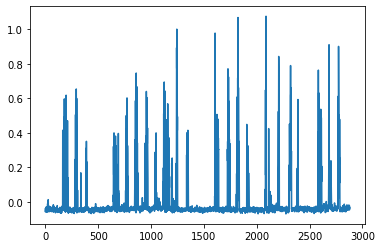

In [9]:
plt.plot(pcs[:,0])

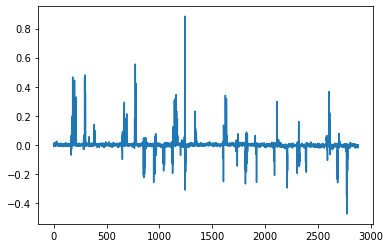

In [10]:
plt.plot(pcs[:,1])

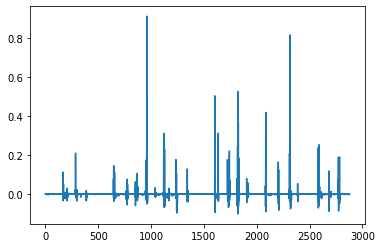

In [12]:
plt.plot(pcs[:,2])

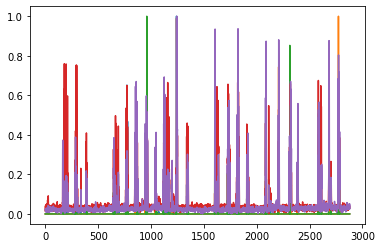

In [7]:
for j in range(0,5):
    plt.plot(behavior[j,:])

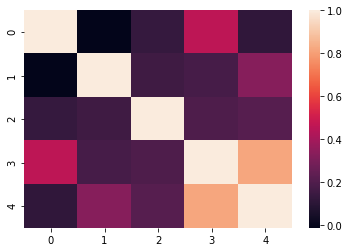

In [13]:
import seaborn as sns

sns.heatmap(np.corrcoef(behavior))

# Behavior Correlation

In [18]:
import time

def compute_beh_corr(pc):
    start=time.time()
    corr_arr=[]   
    for t in range(0,2800,100):
        print(t)
        corr_lst=[]
        for j in range(0,83205):
            corr_lst.append(np.corrcoef(pc[t:(t+100)],neural_dat[t:(t+100),j])[0,1])
        corr_arr.append(corr_lst)
    end=time.time()
    print('Time: ', end-start)
    corr_arr=np.array(corr_arr)
    np.save('/media/maria/DATA1/Documents/ZebraFish/plots/beh_corr_arrays/beh.npy',corr_arr)
    
compute_beh_corr(pcs[:,0])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
Time:  255.14668989181519


In [22]:
corr_arr=np.load('/media/maria/DATA1/Documents/ZebraFish/plots/beh_corr_arrays/beh.npy')

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


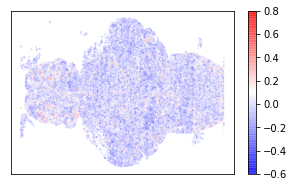

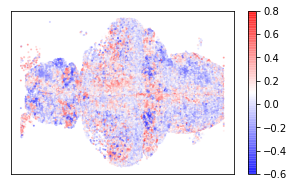

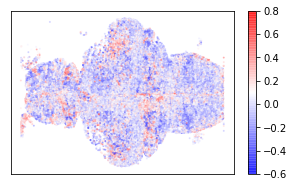

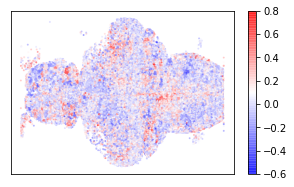

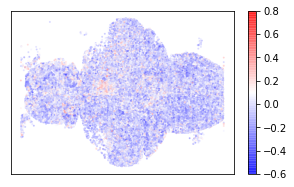

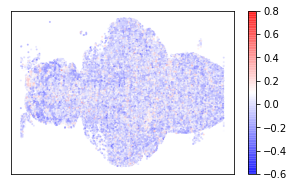

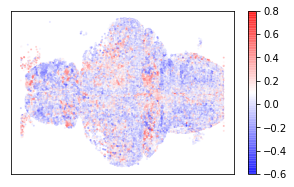

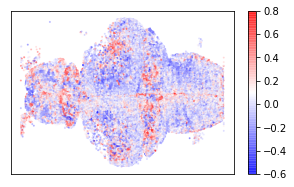

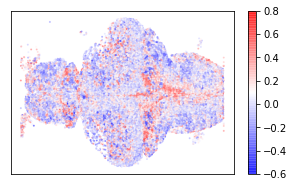

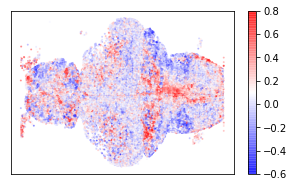

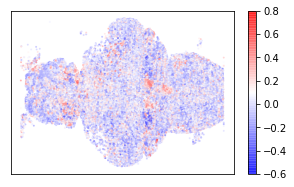

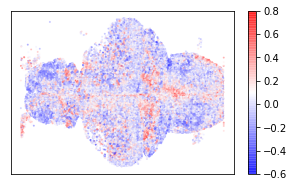

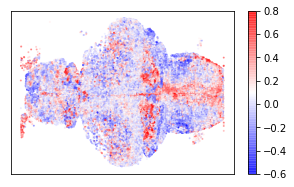

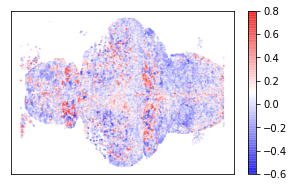

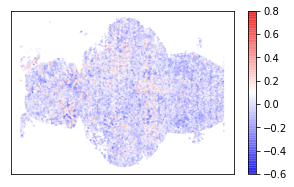

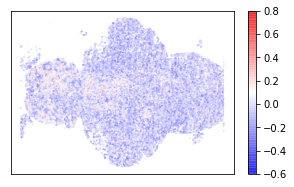

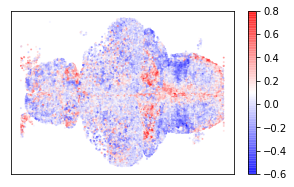

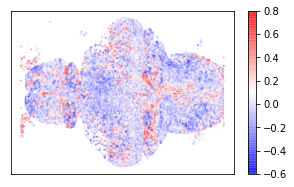

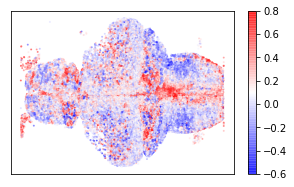

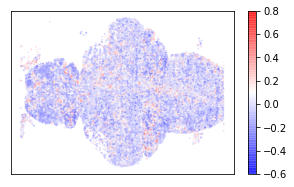

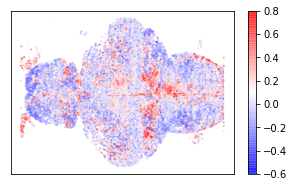

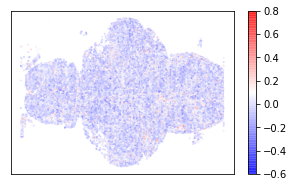

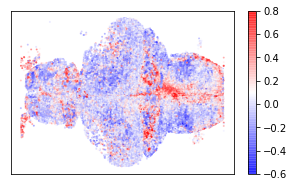

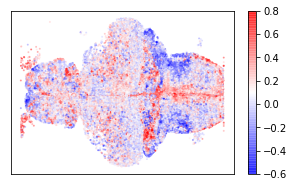

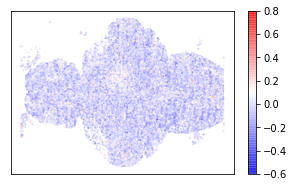

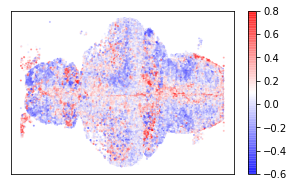

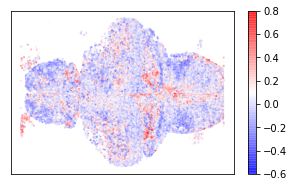

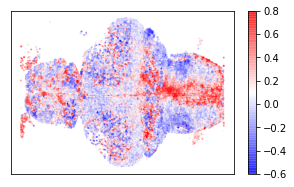

In [24]:
def make_image_files_beh(corr_arr):
    for j in range(0,28):
        fig = plt.figure(figsize=(5,3))
        plt.scatter(cell_pos[:,0], cell_pos[:,1], s = 1, c = corr_arr[j], cmap='bwr', alpha = .5, vmax=0.8, vmin=-0.6)
        plt.colorbar()
        #plt.show()
        plt.xticks([])
        plt.yticks([])
        plt.savefig('/media/maria/DATA1/Documents/ZebraFish/plots/beh_plots/plot_'+str(j)+'.png')
make_image_files_beh(corr_arr)

In [25]:
import imageio
images = []
filenames=['/media/maria/DATA1/Documents/ZebraFish/plots/beh_plots/plot_'+str(j)+'.png' for j in range(0,28)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/media/maria/DATA1/Documents/ZebraFish/plots/beh_plots/beh_plots.gif', images,fps=3)

# DBScan

In [ ]:
from sklearn.cluster import DBSCAN
>>> import numpy as np
>>> X = np.array([[1, 2], [2, 2], [2, 3],
...               [8, 7], [8, 8], [25, 80]])
>>> clustering = DBSCAN(eps=3, min_samples=2).fit(X)

In [4]:
change_points=[]
for j in range(0,stim.shape[0]-1):
    if stim[j]!=stim[j+1]:
        change_points.append(j)
        
times=[]
for j in range(0,len(change_points)-1):
    times.append(change_points[j+1]-change_points[j])

0
(10000,)
time:  4.8508570194244385
[[0 0 0 ... 0 0 0]]


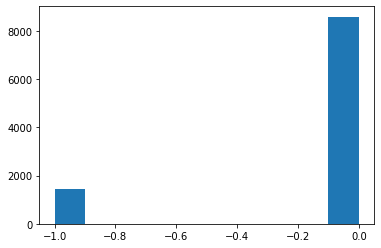

In [18]:
from sklearn.cluster import  DBSCAN
from scipy.signal import medfilt
import time
nn=neural_dat[:,np.random.choice(range(83205),10000,replace=False)]
def db_array(times,neural_dat):
    running=0
    db_arr=[]
    start=time.time()
    for t in range(0,1):
        t=30
        to_cluster=medfilt(neural_dat[running:running+t,:])
        print(running)
        db=DBSCAN(n_jobs=-1,eps=0.5,metric='manhattan').fit(to_cluster.T)
        clusters=db.labels_
        print(clusters.shape)
        db_arr.append(clusters)
        running+=t
    end=time.time()
    print('time: ', end-start)
    db_arr=np.array(db_arr)
    print(db_arr)
    plt.hist(db_arr.flatten())
    plt.show()
    return db_arr
db_array=db_array(times,nn)
np.save('db_array.np',db_array)

# EnsemblePursuit

In [43]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
np.random.seed(0)
rand=np.random.choice(range(83205),10000,replace=False)
ep=EnsemblePursuit(n_components=1,lam=0.05,n_kmeans=1)
running=30
t=30
ep.fit(neural_dat[running:running+t,rand])
V=ep.components_
U=ep.weights
print(U.shape)

obtained 1 PCs in 0.0665 seconds
initialized 1 clusters with k-means in 0.0632 seconds
ensemble 0, time 1.67, nr neurons 2579, EV 0.0514
average sparsity is 0.2579
(10000, 1)


([], <a list of 0 Text yticklabel objects>)

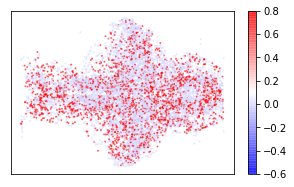

In [44]:
fig = plt.figure(figsize=(5,3))
plt.scatter(cell_pos[rand,0], cell_pos[rand,1], s = 1, c = U[:,0], cmap='bwr', alpha = .5, vmax=0.8, vmin=-0.6)
plt.colorbar()
#plt.show()
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

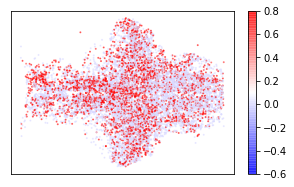

In [33]:
fig = plt.figure(figsize=(5,3))
plt.scatter(cell_pos[rand,0], cell_pos[rand,1], s = 1, c = U[:,0], cmap='bwr', alpha = .5, vmax=0.8, vmin=-0.6)
plt.colorbar()
#plt.show()
plt.xticks([])
plt.yticks([])

0
obtained 1 PCs in 0.0677 seconds
initialized 1 clusters with k-means in 0.0169 seconds
ensemble 0, time 1.99, nr neurons 3135, EV 0.1067
average sparsity is 0.3135


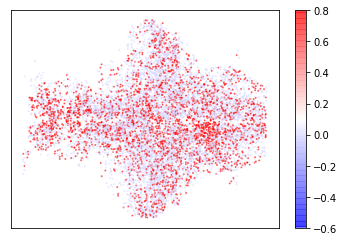

(10000,)
30
obtained 1 PCs in 0.0876 seconds
initialized 1 clusters with k-means in 0.0351 seconds
ensemble 0, time 4.67, nr neurons 6673, EV 0.1469
average sparsity is 0.6651


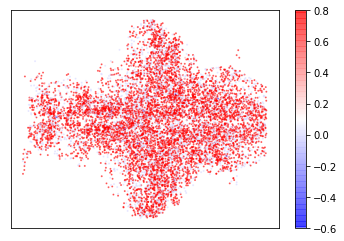

(10000,)
60
obtained 1 PCs in 0.0996 seconds
initialized 1 clusters with k-means in 0.0813 seconds
ensemble 0, time 1.95, nr neurons 3095, EV 0.0779
average sparsity is 0.3095


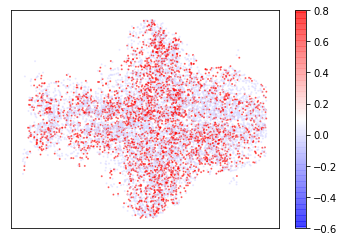

(10000,)
120
obtained 1 PCs in 0.1254 seconds
initialized 1 clusters with k-means in 0.0613 seconds
ensemble 0, time 6.26, nr neurons 8283, EV 0.3410
average sparsity is 0.7835


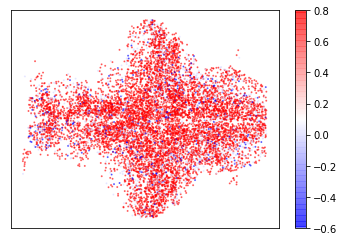

(10000,)
180
obtained 1 PCs in 0.1234 seconds
initialized 1 clusters with k-means in 0.0668 seconds
ensemble 0, time 6.22, nr neurons 8352, EV 0.2489
average sparsity is 0.7750


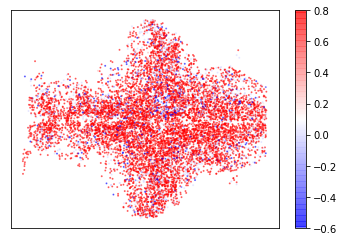

(10000,)
240
obtained 1 PCs in 0.1658 seconds
initialized 1 clusters with k-means in 0.0590 seconds
ensemble 0, time 5.07, nr neurons 7238, EV 0.2174
average sparsity is 0.7085


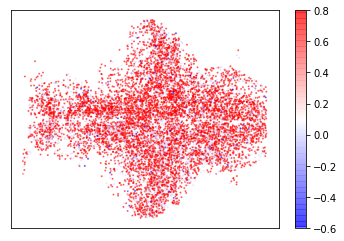

(10000,)
270
obtained 1 PCs in 0.0591 seconds
initialized 1 clusters with k-means in 0.0647 seconds


KeyboardInterrupt: 

In [52]:
def ep_array(times,neural_dat):
    running=0
    ep_arr=[]
    start=time.time()
    for t in times:
        #t=30
        to_cluster=medfilt(neural_dat[running:running+t,:])
        print(running)
        ep=EnsemblePursuit(n_components=1,lam=0.1,n_kmeans=1)
        ep.fit(to_cluster)
        clusters=ep.weights.flatten()
        plt.scatter(cell_pos[rand,0], cell_pos[rand,1], s = 1, c = clusters, cmap='bwr', alpha = .5, vmax=0.8, vmin=-0.6)
        plt.colorbar()
        #plt.show()
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print(clusters.shape)
        ep_arr.append(clusters)
        running+=t
    end=time.time()
    print('time: ', end-start)
    ep_arr=np.array(ep_arr)
    print(ep_arr)
    #plt.hist(ep_arr.flatten())
    #plt.show()
    return ep_arr
rand=np.random.choice(range(83205),10000,replace=False)
rand_n=neural_dat[:,rand]
ep_array=ep_array(times,rand_n)
np.save('ep_array.np',ep_array)